## Import Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Convert Raw video datasets into a 320x240 at 20fps

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 320, 240  # Setting the requested resolution

def downgrade_video(input_video_path, output_video_path, target_resolution=(IMAGE_HEIGHT, IMAGE_WIDTH), target_fps=20):
    """
    Downgrades a video to a specified resolution and frame rate.

    Args:
        input_video_path (str): Path to the input video file.
        output_video_path (str): Path to save the output downgraded video file.
        target_resolution (tuple): Target width and height for the video frames.
        target_fps (int): Target frames per second for the output video.
    """
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {input_video_path}")
        return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, target_fps, target_resolution)

    if not out.isOpened():
        print(f"Error: Could not open video writer for: {output_video_path}")
        cap.release()
        out.release()
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame, target_resolution)
        out.write(resized_frame)

    cap.release()
    out.release()
    print(f"Downgraded: {input_video_path} to {output_video_path}")


def process_folder_structure(root_folder='raw'):  # Default input folder is 'raw'
    """
    Processes the folder structure to downgrade videos and save them in a new structure.

    Args:
        root_folder (str): Path to the root folder containing class folders.
    """
    output_root_folder = 'downgraded_raw'  # Output folder is fixed to 'downgraded_raw'
    os.makedirs(output_root_folder, exist_ok=True)

    class_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for class_name in class_folders:
        output_class_folder = os.path.join(output_root_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)

        input_class_folder = os.path.join(root_folder, class_name)
        video_files = [f for f in os.listdir(input_class_folder) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

        for video_file in video_files:
            input_video_path = os.path.join(input_class_folder, video_file)
            output_video_name = os.path.splitext(video_file)[0] + '_downgraded.mp4'
            output_video_path = os.path.join(output_class_folder, output_video_name)

            downgrade_video(input_video_path, output_video_path)


if __name__ == "__main__":
    input_root_folder = 'raw'  # Input folder is now hardcoded to 'raw'

    if not os.path.isdir(input_root_folder):
        print(f"Error: 'raw' folder not found in the same directory as the script.")
        sys.exit(1)

    process_folder_structure(input_root_folder)
    print(f"Downgrading process complete. Downgraded videos saved in 'downgraded_raw' folder.")

### Set Numpy, Python, and TF seeds

In [4]:
model_input_size = (224,224,3)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


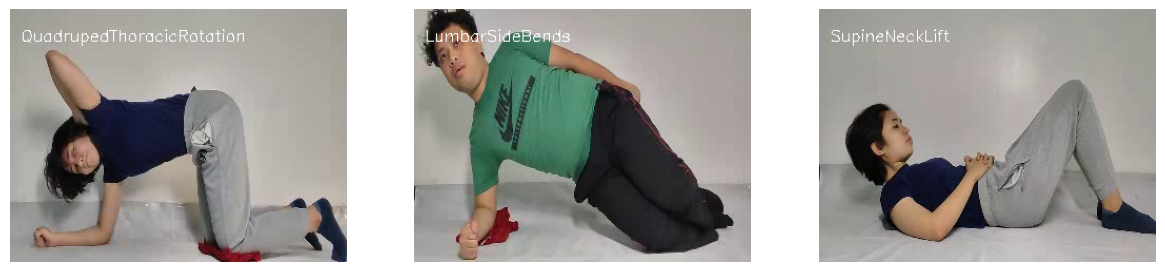

In [18]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [19]:
IMAGE_HEIGHT, IMAGE_WIDTH =  64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = r"D:\MAPUA\CNN_GRU_usingRGBOF\downgraded_raw"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [ ]:
def frames_extraction(video_path):
    #This function will be called after resizing and normalizing frames"

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
           break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255

        frames_list.append(normalized_frame)
    
    video_reader.release()
    
    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(np.zeros_like(frames_list[-1]))
    
    return frames_list


2nd CNN Stream

## Dataset Creation

1st Stream

In [ ]:
def create_dataset_1st():
    #extracts the data of the selected class asnd create the required dataset
    features1 = []
    labels1 = []
    video_files_paths1 = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features1.append(frames)
                labels1.append(class_index)
                video_files_paths1.append(video_file_path)
    
    features1 = np.asarray(features1)
    labels1 = np.array(labels1)

    return features1, labels1, video_files_paths1
            

In [ ]:
#Create the dataset
features1, labels1, video_files_paths1 = create_dataset_1st()

In [ ]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1)

2nd Stream

In [ ]:
def create_dataset_2nd():
    #extracts the data of the selected class asnd create the required dataset
    features2 = []
    labels2 = []
    video_files_paths2 = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features2.append(frames)
                labels2.append(class_index)
                video_files_paths2.append(video_file_path)
    
    features2 = np.asarray(features2)
    labels2 = np.array(labels2)

    return features2, labels2, video_files_paths2
            

In [ ]:
#Create the dataset
features2, labels2, video_files_paths2 = create_dataset_2nd()

In [ ]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2)

## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


For 2nd Stream (OF Data)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


## Implement 2stream Model